<h3>Pipeline For Data Curation </h3>
<h4>First load all starpep data and separate sequences with non-standard amino acids into a separate list </h4>

In [1]:
from Bio import SeqIO
import re
import pandas as pd
import numpy as np
pattern = re.compile("[^ARNDCEQGHILKMFPSTWYV]") #no B asaparctic acid or Z glutamic acid (X,O,B,Z,J,U)
standard = []
non_standard= []
for idx, record in enumerate(SeqIO.parse("amp_100_pep_toolbox_raw.fasta", "fasta")):
    if pattern.search(str(record.seq)):
        non_standard.append(idx) #saving the index of the non-standard AAs for future reference
    else:
        standard.append(record.seq)

print("Are there duplicates:", len(standard) != len(set(standard))) #sets do not allow duplicate values, check if both list lens are equal

print("Number of sequences with only standard AA's: ",len(standard), "\t Number with non-standard AA's",len(non_standard))
sequence_length_dict={'sequences': [str(seq) for seq in standard], 'lengths':[len(seq) for seq in standard]}
pd.DataFrame.from_dict(sequence_length_dict).to_csv('starpep_sequences_and_lengths.csv', index=False)

Are there duplicates: False
Number of sequences with only standard AA's:  42373 	 Number with non-standard AA's 2747


<h4> Then load the uniprot data and separate sequences with standad amino acids into a separate list

In [2]:
pattern = re.compile("[^ARNDCEQGHILKMFPSTWYV]") #no B asaparctic acid or Z glutamic acid (or "X" or "O")
standard = []
non_standard= []
for idx, record in enumerate(SeqIO.parse("uniprot_len_50_std_only_non_antimicrobial.fasta", "fasta")):
    if pattern.search(str(record.seq)):
        non_standard.append(idx) #saving the index of the non-standard AAs for future reference
    else:
        standard.append(record.seq)

print("Are there duplicates:", len(standard) != len(set(standard))) #sets do not allow duplicate values, check if both list lens are equal
standard = list(set(standard))
print("Are there duplicates after removal?:", len(standard) != len(set(standard))) #sets do not allow duplicate values, check if both list lens are equal

print("Number of sequences with only standard AA's: ",len(standard), "\t Number with non-standard AA's",len(non_standard))
sequence_length_dict={'sequences': [str(seq) for seq in standard], 'lengths':[len(seq) for seq in standard]}
pd.DataFrame.from_dict(sequence_length_dict).to_csv('uniprot_sequences_and_lengths.csv', index=False)

Are there duplicates: True
Are there duplicates after removal?: False
Number of sequences with only standard AA's:  2839655 	 Number with non-standard AA's 27439


<h4> Load the function metadata for starpep and re-format it

In [3]:
df_func = pd.read_csv('sequence_function_link_std_only.csv')
with open('starpep_amps_in_order.txt', 'w') as f:
    for sequence, amp_check in zip(df_func['Sequences'], df_func['Antimicrobial']):
        if amp_check==1:
            f.write('antimicrobial\n')
        else:
            f.write('not_antimicrobial\n')
f.close()

<h4> Now load both created csv's with starpep and uniprot sequences of only standard amino acids and combine to create final dataset

In [4]:
df_uni = pd.read_csv('uniprot_sequences_and_lengths.csv')
df_star = pd.read_csv('starpep_sequences_and_lengths.csv')

#loading the functional data for property predictor
df_func = pd.read_csv('starpep_amps_in_order.txt', names=['Antimicrobial'])
df_func["Antimicrobial"] = df_func["Antimicrobial"].map({"antimicrobial":1, "not_antimicrobial":0})

#tie the functional data to starpep and add negative labels to all uniprot data
df_star["Antimicrobial"] = df_func["Antimicrobial"]
df_uni["Antimicrobial"] = 0

df_unistar = pd.concat([df_star,df_uni]) #important to have starpep 1st to keep as many from there as possible!
#check if there were duplicates between starpep and uniprot datasets remove 2nd occurence
df_unistar_duplicates = df_unistar.duplicated(subset='sequences', keep='last') #interested in starpep duplicates
df_unistar_no_duplicates = df_unistar.drop_duplicates(subset='sequences',keep='first') #drop uniprot duplicates
print("found {} duplicates between starpep and uniprot".format(df_unistar.shape[0]- df_unistar_no_duplicates.shape[0]))
starpep_duplicates = amps_found_in_starpep_and_uniprot = df_star.iloc[df_unistar_duplicates.loc[df_unistar_duplicates[:]==True].index]
amps_found_in_starpep_and_uniprot = starpep_duplicates.loc[starpep_duplicates['Antimicrobial']==1]
print("found {} AMPs from starpep in the negative uniprot dataset".format(amps_found_in_starpep_and_uniprot.shape[0]))
print("The second appearance of the duplicates is removed leaving peptides with appropriate function labels from Starpep")
#let's make sure all the starpep peptides are in our dataset
temp_df = pd.concat([df_star, df_unistar_no_duplicates]).duplicated(subset='sequences', keep='last')
print("found {} / {} peptides from starpep in joined dataset".format(temp_df.loc[temp_df[:]==True].shape[0], df_star.shape[0]))

#keep only max of 7000 sequences for each length
df_sunistar = pd.DataFrame() #small uniprot+starpep = sunistar
for length in range(51):
    cur_len_df = df_unistar_no_duplicates.loc[df_unistar_no_duplicates ['lengths']==length] 
    df_sunistar = df_sunistar.append(cur_len_df[:7000])  

#Check that all starpep peptides with length <=50 are in our dataset
temp_df = pd.concat([df_star, df_sunistar]).duplicated(subset='sequences', keep='last')
print("Have {} out of expected {} peptides with length <=50 from starpep in joined dataset".format(temp_df.loc[temp_df[:]==True].shape[0],
                                                                                                    df_star.loc[df_star['lengths']<=50].shape[0]) )
#save datasets
with open('sunistar.txt', 'w') as f:
    for seq in df_sunistar['sequences'].to_numpy():
        f.write(seq)
        f.write('\n')  

with open('functions.txt', 'w') as f:
    for func in df_sunistar['Antimicrobial'].to_numpy():
        f.write(str(func))
        f.write('\n')

found 2100 duplicates between starpep and uniprot
found 317 AMPs from starpep in the negative uniprot dataset
The second appearance of the duplicates is removed leaving peptides with appropriate function labels from Starpep
found 42373 / 42373 peptides from starpep in joined dataset
Have 35806 out of expected 35806 peptides with length <=50 from starpep in joined dataset


In [5]:
print("fraction of datasaet that is starpep = {} / {} = {:.4f}".format(df_star.loc[df_star['lengths']<=50].shape[0], df_sunistar.shape[0], df_star.loc[df_star['lengths']<=50].shape[0]/df_sunistar.shape[0]))
print("peptides from Uniprot {}".format(df_sunistar.shape[0]-df_star.loc[df_star['lengths']<=50].shape[0]))
print("number of amps in dataset: ",df_sunistar.loc[df_sunistar['Antimicrobial']==1].shape[0])

fraction of datasaet that is starpep = 35806 / 304001 = 0.1178
peptides from Uniprot 268195
number of amps in dataset:  10841


<h4> Now that we have the full dataset we can split into train and test sets and shuffle the data

In [40]:
import random

sequences=[]
with open('sunistar.txt') as f:
    sequences= [line.strip('\na') for line in f]
f.close()

function_list = list(df_sunistar['Antimicrobial'])

random.seed(0) # set the seed so shuffling is reproducible
random_indices = np.linspace(0,len(sequences)-1, len(sequences)).astype(np.int)
random.shuffle(random_indices)
sequences = [sequences[i] for i in random_indices]
function_list= [function_list[i] for i in random_indices]

with open('final_dataset/peptide_train.txt', 'w') as f:
    f.write("peptides\n")
    for idx,line in enumerate(sequences):
        if idx <round(0.20*len(sequences)):
            continue
        f.write(str(line)+'\n')
f.close()

with open('final_dataset/peptide_test.txt', 'w') as f:
    f.write("peptides\n")
    for idx,line in enumerate(sequences):
        if idx <round(0.20*len(sequences)):
            f.write(str(line)+'\n')
        else:
            break
f.close()

with open('final_dataset/function_train.txt', 'w') as f:
    f.write("peptides\n")
    for idx,line in enumerate(function_list):
        if idx <round(0.20*len(function_list)):
            continue
        f.write(str(line)+'\n')
f.close()

with open('final_dataset/function_test.txt', 'w') as f:
    f.write("peptides\n")
    for idx,line in enumerate(function_list):
        if idx <round(0.20*len(function_list)):
            f.write(str(line)+'\n')
        else:
            break
f.close()


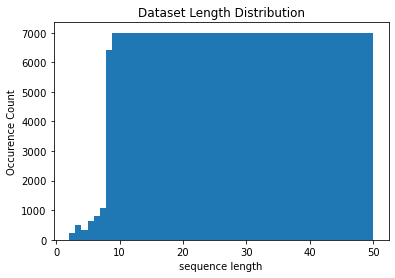

In [41]:
import matplotlib.pyplot as plt
plt.title("Dataset Length Distribution")
plt.xlabel("sequence length")
plt.ylabel("Occurence Count")
plt.hist(df_sunistar['lengths'], bins=49,)
plt.savefig('dataset_length_distribution.png',facecolor='white',transparent=None, dpi=600)

<H3> Need to create token dictionnary and weights to rescale values for training

In [42]:
import sys
sys.path.append('../../') #allows import from 2 dirs above the CWD
inputs = 'final_dataset/peptide_train.txt'
max_len = 50 #max length of the sequence
save_dir = "final_dataset/"
vocab_name = 'char_dict_peptide'
weights_name = 'char_weights_peptide'

%run ../../scripts/build_vocab.py --inputs $inputs --max_len $max_len --save_dir $save_dir --vocab_name $vocab_name --weights_name $weights_name

building dictionary...
calculating weights...
{'M': 295902, 'K': 451069, 'Y': 202789, 'C': 167740, 'S': 484447, 'Q': 243903, 'G': 446551, 'T': 362556, 'V': 441128, 'A': 509749, 'L': 685260, 'R': 449304, 'I': 429098, 'P': 308972, 'D': 285789, 'F': 315026, 'H': 161479, 'E': 362688, 'N': 279440, 'W': 107690, '_': 5169470, '<end>': 243201}
